# Matching Intuition

**Chapter 10, Section 1**

This notebook covers the fundamental intuition behind matching estimators: finding "twins" in the data.

## Table of Contents
1. [Intuition](#intuition) - Finding twins with same X
2. [Formal Treatment](#formal) - Matching as nonparametric estimation
3. [Numeric Demonstration](#numeric) - Job training example
4. [Implementation](#implementation) - Exact and approximate matching
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### The Matching Idea: Find Twins

The core insight of matching is deceptively simple:

> **For each treated unit, find a similar control unit. Compare their outcomes.**

If we could find perfect "twins" - identical in every way except treatment - then comparing them reveals the causal effect.

### Why Matching Works

Consider the fundamental problem: We observe $Y_i$ for treated units, but we want to know what would have happened without treatment ($Y_i(0)$).

**Matching strategy**: Find a control unit $j$ with the same covariates as treated unit $i$:
- Unit $i$: Treated, with $X_i$
- Unit $j$: Control, with $X_j \approx X_i$

If $X_j = X_i$, then under conditional ignorability:
$$E[Y_j | X_j = X_i] = E[Y_i(0) | X_i]$$

The control unit's outcome estimates the treated unit's counterfactual!

### Regression as Implicit Matching

Linear regression actually does a form of matching, but with strong assumptions:

| Approach | Assumption | Flexibility |
|----------|------------|-------------|
| **Regression** | Linear relationship | Low (parametric) |
| **Matching** | Similar units comparable | High (nonparametric) |

Regression "averages" across all units with different weights. Matching explicitly finds comparable pairs.

$$\hat{\tau}_{reg} = \bar{Y}_1 - \bar{Y}_0 + \hat{\beta}'(\bar{X}_0 - \bar{X}_1)$$

The regression adjustment term implicitly "matches" by adjusting for covariate differences.

---

In [2]:
# Load job training data
trainee_df = load_facure_data("trainees.csv")

print(f"Data: {len(trainee_df)} individuals")
print(f"Treatment (training): {trainee_df['trainees'].mean():.1%} received training")
print(f"\nColumns: {list(trainee_df.columns)}")
trainee_df.head(10)

Data: 40 individuals
Treatment (training): 47.5% received training

Columns: ['unit', 'trainees', 'age', 'earnings']


,unit,trainees,age,earnings
0,1,1,28,17700
1,2,1,34,10200
2,3,1,29,14400
3,4,1,25,20800
4,5,1,29,6100
5,6,1,23,28600
6,7,1,33,21900
7,8,1,27,28800
8,9,1,31,20300
9,10,1,26,28100


In [3]:
# This is observational data - trainees self-selected
# Check covariate imbalance
print("Covariate means by treatment status:")
balance = trainee_df.groupby('trainees')[['age', 'earnings']].mean()
print(balance)
print(f"\nAge difference: {balance.loc[1, 'age'] - balance.loc[0, 'age']:.1f} years")
print(f"Earnings difference: ${balance.loc[1, 'earnings'] - balance.loc[0, 'earnings']:.0f}")

Covariate means by treatment status:
             age   earnings
trainees                   
0        33.0000 20723.8095
1        28.4737 16426.3158

Age difference: -4.5 years
Earnings difference: $-4297


---

## Formal Treatment

### The Matching Estimator

**Definition** (Matching Estimator for ATT):

$$\hat{\tau}_{match} = \frac{1}{N_1} \sum_{i: T_i=1} \left[ Y_i - Y_{j(i)} \right]$$

where:
- $N_1$ = number of treated units
- $j(i)$ = the control unit matched to treated unit $i$
- $Y_{j(i)}$ = outcome of the matched control

### Key Assumptions

**Assumption 1** (Conditional Ignorability):
$$\{Y(0), Y(1)\} \perp T \mid X$$

Treatment assignment is random conditional on observed covariates.

**Assumption 2** (Overlap/Positivity):
$$0 < P(T=1 \mid X=x) < 1 \quad \forall x \in \mathcal{X}$$

Every covariate pattern has both treated and control units.

**Assumption 3** (SUTVA):
- No interference between units
- No hidden versions of treatment

### Identification Result

**Theorem** (Matching Identifies ATT):

Under assumptions 1-3, if matching is exact ($X_i = X_{j(i)}$):

$$E[\hat{\tau}_{match}] = E[Y(1) - Y(0) \mid T=1] = \tau_{ATT}$$

**Proof sketch**:
1. For each treated unit $i$: $E[Y_i \mid T_i=1, X_i] = E[Y(1) \mid X_i]$
2. For matched control $j(i)$: $E[Y_j \mid T_j=0, X_j=X_i] = E[Y(0) \mid X_i]$
3. By conditional ignorability: $E[Y(0) \mid X_i] = E[Y(0) \mid T=1, X_i]$
4. Therefore: $E[Y_i - Y_{j(i)}] = E[Y(1) - Y(0) \mid T=1, X_i]$
5. Averaging over treated units gives ATT.

---

In [4]:
# Naive comparison (ignoring confounders)
treated = trainee_df[trainee_df['trainees'] == 1]
control = trainee_df[trainee_df['trainees'] == 0]

naive_effect = treated['earnings'].mean() - control['earnings'].mean()

print("NAIVE COMPARISON (ignoring age):")
print(f"  Mean earnings (treated):  ${treated['earnings'].mean():.0f}")
print(f"  Mean earnings (control):  ${control['earnings'].mean():.0f}")
print(f"  Naive effect:             ${naive_effect:.0f}")
print(f"\nBut trainees are {balance.loc[1, 'age'] - balance.loc[0, 'age']:.0f} years older on average!")
print("Older workers earn more regardless of training.")

NAIVE COMPARISON (ignoring age):
  Mean earnings (treated):  $16426
  Mean earnings (control):  $20724
  Naive effect:             $-4297

But trainees are -5 years older on average!
Older workers earn more regardless of training.


---

## Numeric Demonstration

### Exact Matching on Age

The simplest matching strategy: for each treated unit, find a control unit with the **exact same** covariate value.

In [5]:
def exact_matching_att(df, outcome_col, treatment_col, match_col):
    """
    Estimate ATT using exact matching on a single covariate.
    
    For each treated unit, find control units with exact same covariate value.
    Use mean of matched controls as counterfactual.
    """
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    
    matched_effects = []
    unmatched_count = 0
    
    for idx, row in treated.iterrows():
        # Find controls with exact same covariate value
        match_value = row[match_col]
        matched_controls = control[control[match_col] == match_value]
        
        if len(matched_controls) > 0:
            # Average outcome of matched controls
            counterfactual = matched_controls[outcome_col].mean()
            individual_effect = row[outcome_col] - counterfactual
            matched_effects.append({
                'treated_id': idx,
                'treated_outcome': row[outcome_col],
                'match_value': match_value,
                'n_matches': len(matched_controls),
                'counterfactual': counterfactual,
                'individual_effect': individual_effect
            })
        else:
            unmatched_count += 1
    
    if len(matched_effects) == 0:
        raise ValueError("No treated units could be matched!")
    
    results_df = pd.DataFrame(matched_effects)
    att = results_df['individual_effect'].mean()
    se = results_df['individual_effect'].std() / np.sqrt(len(results_df))
    
    return {
        'ATT': att,
        'SE': se,
        'n_matched': len(results_df),
        'n_unmatched': unmatched_count,
        'match_rate': len(results_df) / len(treated),
        'details': results_df
    }

In [6]:
# Apply exact matching on age
result = exact_matching_att(trainee_df, 'earnings', 'trainees', 'age')

print("EXACT MATCHING RESULTS:")
print("=" * 50)
print(f"ATT (training effect): ${result['ATT']:.0f}")
print(f"Standard Error: ${result['SE']:.0f}")
print(f"95% CI: [${result['ATT'] - 1.96*result['SE']:.0f}, ${result['ATT'] + 1.96*result['SE']:.0f}]")
print(f"\nMatched: {result['n_matched']} treated units ({result['match_rate']:.1%})")
print(f"Unmatched: {result['n_unmatched']} treated units")

print(f"\nComparison:")
print(f"  Naive (biased): ${naive_effect:.0f}")
print(f"  Matching:       ${result['ATT']:.0f}")
print(f"  Bias removed:   ${naive_effect - result['ATT']:.0f}")

EXACT MATCHING RESULTS:
ATT (training effect): $2450
Standard Error: $2450
95% CI: [$-2352, $7252]

Matched: 19 treated units (100.0%)
Unmatched: 0 treated units

Comparison:
  Naive (biased): $-4297
  Matching:       $2450
  Bias removed:   $-6747


In [7]:
# Show matching details
print("\nMatching Details (first 10 treated units):")
details = result['details'].head(10)
print(details[['treated_outcome', 'match_value', 'n_matches', 'counterfactual', 'individual_effect']].to_string(index=False))


Matching Details (first 10 treated units):
 treated_outcome  match_value  n_matches  counterfactual  individual_effect
           17700           28          1       8800.0000          8900.0000
           10200           34          1      24200.0000        -14000.0000
           14400           29          1       6200.0000          8200.0000
           20800           25          1      23300.0000         -2500.0000
            6100           29          1       6200.0000          -100.0000
           28600           23          1       9500.0000         19100.0000
           21900           33          1      15500.0000          6400.0000
           28800           27          1       9300.0000         19500.0000
           20300           31          1      26600.0000         -6300.0000
           28100           26          2       8450.0000         19650.0000


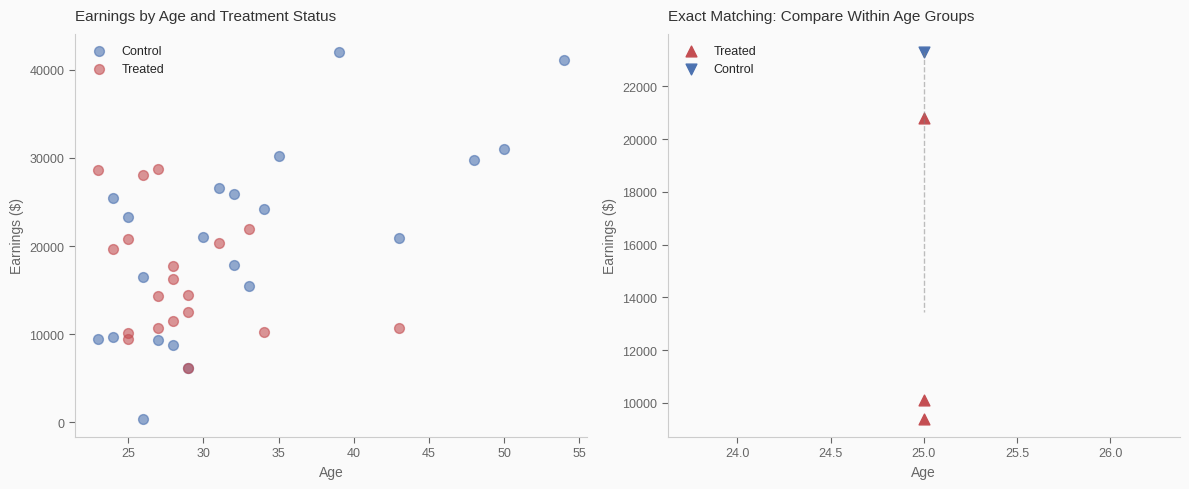

In [8]:
# Visualize the matching process
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 5))

# Left: Earnings by age and treatment
ax = axes[0]
for t_val, color, label in [(0, COLORS['blue'], 'Control'), (1, COLORS['red'], 'Treated')]:
    subset = trainee_df[trainee_df['trainees'] == t_val]
    ax.scatter(subset['age'], subset['earnings'], alpha=0.6, c=color, label=label, s=50)

set_tufte_title(ax, "Earnings by Age and Treatment Status")
set_tufte_labels(ax, "Age", "Earnings ($)")
ax.legend(frameon=False)

# Right: Matching illustration for specific ages
ax = axes[1]

# Show matched pairs for a few age values
ages_to_show = [25, 30, 35, 40]
for i, age in enumerate(ages_to_show):
    treated_at_age = trainee_df[(trainee_df['trainees'] == 1) & (trainee_df['age'] == age)]['earnings']
    control_at_age = trainee_df[(trainee_df['trainees'] == 0) & (trainee_df['age'] == age)]['earnings']
    
    if len(treated_at_age) > 0 and len(control_at_age) > 0:
        # Plot treated (top) and control (bottom)
        ax.scatter([age]*len(treated_at_age), treated_at_age, 
                   c=COLORS['red'], s=60, marker='^', label='Treated' if i==0 else '')
        ax.scatter([age]*len(control_at_age), control_at_age, 
                   c=COLORS['blue'], s=60, marker='v', label='Control' if i==0 else '')
        
        # Draw line showing comparison
        ax.vlines(age, control_at_age.mean(), treated_at_age.mean(), 
                  colors='gray', linestyles='--', linewidth=1, alpha=0.5)

set_tufte_title(ax, "Exact Matching: Compare Within Age Groups")
set_tufte_labels(ax, "Age", "Earnings ($)")
ax.legend(frameon=False, loc='upper left')

plt.tight_layout()
plt.show()

### Subclassification View

Exact matching is equivalent to **subclassification** - stratifying by covariate and comparing within strata:

$$\hat{\tau}_{strat} = \sum_x \frac{N_{1x}}{N_1} \cdot (\bar{Y}_{1x} - \bar{Y}_{0x})$$

where:
- $N_{1x}$ = treated units with covariate value $x$
- $\bar{Y}_{1x}$ = mean outcome for treated with $X=x$
- $\bar{Y}_{0x}$ = mean outcome for control with $X=x$

This is a weighted average of within-stratum treatment effects.

In [9]:
# Demonstrate equivalence to subclassification
def subclassification_att(df, outcome_col, treatment_col, strata_col):
    """
    Estimate ATT using subclassification (stratification).
    """
    treated = df[df[treatment_col] == 1]
    
    strata_effects = []
    
    for stratum in df[strata_col].unique():
        stratum_data = df[df[strata_col] == stratum]
        treated_stratum = stratum_data[stratum_data[treatment_col] == 1]
        control_stratum = stratum_data[stratum_data[treatment_col] == 0]
        
        if len(treated_stratum) > 0 and len(control_stratum) > 0:
            effect = treated_stratum[outcome_col].mean() - control_stratum[outcome_col].mean()
            weight = len(treated_stratum) / len(treated)
            strata_effects.append({
                'stratum': stratum,
                'n_treated': len(treated_stratum),
                'n_control': len(control_stratum),
                'effect': effect,
                'weight': weight,
                'weighted_effect': effect * weight
            })
    
    strata_df = pd.DataFrame(strata_effects)
    att = strata_df['weighted_effect'].sum()
    
    return att, strata_df

subclass_att, strata_df = subclassification_att(trainee_df, 'earnings', 'trainees', 'age')

print("SUBCLASSIFICATION RESULTS:")
print("=" * 50)
print(f"Subclassification ATT: ${subclass_att:.0f}")
print(f"Exact Matching ATT:    ${result['ATT']:.0f}")
print(f"\nThese are equivalent methods!")

print(f"\nStrata details (first 10 ages):")
print(strata_df.head(10).to_string(index=False))

SUBCLASSIFICATION RESULTS:
Subclassification ATT: $2450
Exact Matching ATT:    $2450

These are equivalent methods!

Strata details (first 10 ages):
 stratum  n_treated  n_control      effect  weight  weighted_effect
      28          3          1   6366.6667  0.1579        1005.2632
      34          1          1 -14000.0000  0.0526        -736.8421
      29          3          1   4800.0000  0.1579         757.8947
      25          3          1  -9866.6667  0.1579       -1557.8947
      23          1          1  19100.0000  0.0526        1005.2632
      33          1          1   6400.0000  0.0526         336.8421
      27          3          1   8633.3333  0.1579        1363.1579
      31          1          1  -6300.0000  0.0526        -331.5789
      26          1          2  19650.0000  0.0526        1034.2105
      24          1          2   2100.0000  0.0526         110.5263


---

## Implementation

### Regression Comparison

How does matching compare to regression adjustment?

In [10]:
# Compare matching to regression
model = smf.ols('earnings ~ trainees + age', data=trainee_df).fit()

print("REGRESSION vs MATCHING:")
print("=" * 50)
print(f"\nNaive (no adjustment):     ${naive_effect:.0f}")
print(f"Regression (linear adj):   ${model.params['trainees']:.0f}")
print(f"Exact Matching:            ${result['ATT']:.0f}")

print(f"\nRegression details:")
print(model.summary().tables[1])

REGRESSION vs MATCHING:

Naive (no adjustment):     $-4297
Regression (linear adj):   $-1541
Exact Matching:            $2450

Regression details:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    626.9025   6447.463      0.097      0.923   -1.24e+04    1.37e+04
trainees   -1540.9802   2774.066     -0.555      0.582   -7161.772    4079.812
age          608.9972    187.429      3.249      0.002     229.229     988.765


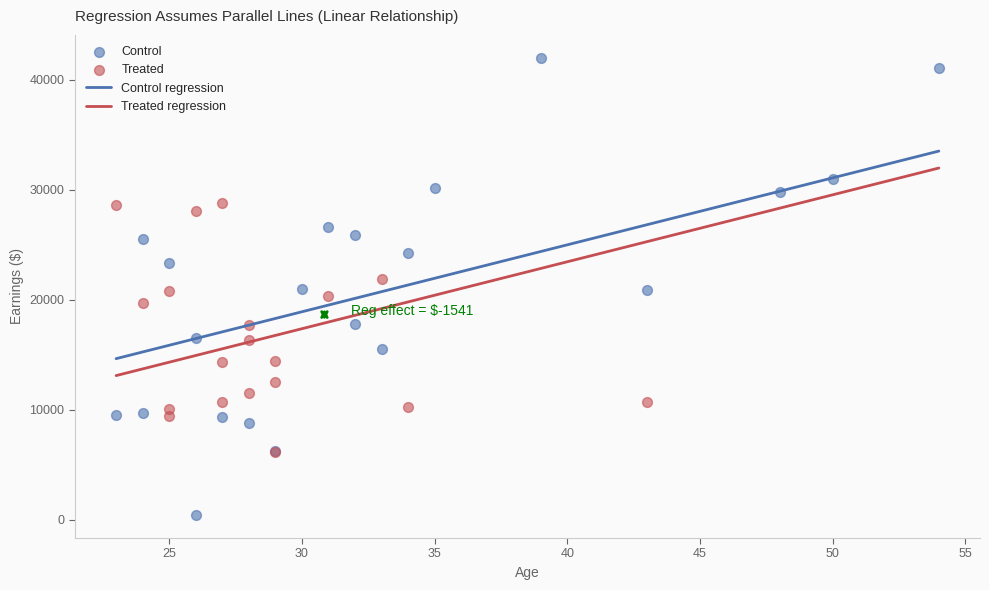

Regression assumes the treatment effect is constant across all ages.
Matching is more flexible - it allows different effects at different ages.


In [11]:
# Visualize regression vs matching
fig, ax = create_tufte_figure(figsize=(10, 6))

# Scatter plot
for t_val, color, label in [(0, COLORS['blue'], 'Control'), (1, COLORS['red'], 'Treated')]:
    subset = trainee_df[trainee_df['trainees'] == t_val]
    ax.scatter(subset['age'], subset['earnings'], alpha=0.6, c=color, label=label, s=50)

# Regression lines
ages = np.array([trainee_df['age'].min(), trainee_df['age'].max()])
ax.plot(ages, model.params['Intercept'] + model.params['age'] * ages, 
        color=COLORS['blue'], linewidth=2, linestyle='-', label='Control regression')
ax.plot(ages, model.params['Intercept'] + model.params['trainees'] + model.params['age'] * ages, 
        color=COLORS['red'], linewidth=2, linestyle='-', label='Treated regression')

# Annotate the treatment effect
mid_age = trainee_df['age'].mean()
y_control = model.params['Intercept'] + model.params['age'] * mid_age
y_treated = y_control + model.params['trainees']
ax.annotate('', xy=(mid_age, y_treated), xytext=(mid_age, y_control),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax.text(mid_age + 1, (y_control + y_treated)/2, f'Reg effect = ${model.params["trainees"]:.0f}',
        fontsize=10, color='green')

set_tufte_title(ax, "Regression Assumes Parallel Lines (Linear Relationship)")
set_tufte_labels(ax, "Age", "Earnings ($)")
ax.legend(frameon=False, loc='upper left')

plt.tight_layout()
plt.show()

print("Regression assumes the treatment effect is constant across all ages.")
print("Matching is more flexible - it allows different effects at different ages.")

### Key Differences: Matching vs Regression

| Aspect | Regression | Matching |
|--------|------------|----------|
| **Functional form** | Assumes linear (or specified) | Nonparametric |
| **Extrapolation** | Extrapolates beyond data | Only uses observed values |
| **Overlap** | Implicit (can hide violations) | Explicit (unmatched units visible) |
| **Efficiency** | More efficient if linear | Less efficient but robust |
| **Heterogeneity** | Requires interaction terms | Naturally captures heterogeneity |

The matching approach makes the comparison explicit and visible. If there's no overlap (no control units at a certain age), matching tells you immediately.

In [12]:
# Check overlap explicitly
treated_ages = set(trainee_df[trainee_df['trainees'] == 1]['age'].unique())
control_ages = set(trainee_df[trainee_df['trainees'] == 0]['age'].unique())

overlap_ages = treated_ages & control_ages
no_match_ages = treated_ages - control_ages

print("OVERLAP ANALYSIS:")
print("=" * 50)
print(f"Treated age range: {min(treated_ages)} to {max(treated_ages)}")
print(f"Control age range: {min(control_ages)} to {max(control_ages)}")
print(f"\nOverlap ages: {len(overlap_ages)} values")
print(f"Treated ages with no control match: {sorted(no_match_ages) if no_match_ages else 'None'}")

if no_match_ages:
    n_unmatched = sum(trainee_df[(trainee_df['trainees'] == 1) & (trainee_df['age'].isin(no_match_ages))]['trainees'])
    print(f"\nWarning: {n_unmatched} treated units cannot be matched!")

OVERLAP ANALYSIS:
Treated age range: 23 to 43
Control age range: 23 to 54

Overlap ages: 11 values
Treated ages with no control match: None


---

## Production Implementation

This method is implemented in the `causal_inference_mastery` library:

```python
from causal_inference.psm.matching import (
    exact_matching,
    nearest_neighbor_matching,
    caliper_matching,
    MatchingResult
)
from causal_inference.psm.balance import standardized_mean_difference, balance_plot

# Exact matching (for discrete covariates)
result = exact_matching(
    outcome=data['earnings'],
    treatment=data['trainees'],
    covariates=data[['age', 'gender']],
    replacement=False
)
print(f"ATT: {result.att:.4f}")
print(f"Matched: {result.n_matched} of {result.n_treated} treated units")

# Nearest neighbor matching (for continuous covariates)
result = nearest_neighbor_matching(
    outcome=data['earnings'],
    treatment=data['trainees'],
    covariates=data[['age', 'income', 'education']],
    n_neighbors=1,
    distance='mahalanobis',
    replacement=True
)
print(f"ATT: {result.att:.4f}")
print(f"SE (Abadie-Imbens): {result.se:.4f}")

# Balance diagnostics
smd = standardized_mean_difference(
    covariates=data[['age', 'income']],
    treatment=data['trainees'],
    weights=result.weights  # After matching
)
print(f"SMD after matching: {smd}")
```

**Key differences from notebook demo**:
- Production code implements Abadie-Imbens standard errors for matching
- Supports with/without replacement and caliper constraints
- Mahalanobis and propensity score distance metrics
- Automatic balance diagnostics with love plots
- Cross-validated with Julia implementation

**See also**: `causal_inference_mastery/src/causal_inference/psm/`

⚠️ **Methodological Concern** (CONCERN-5): Bootstrap standard errors are INVALID for matching with replacement. Use Abadie-Imbens variance estimator.

---

## Interview Appendix

### Practice Questions

**Q1: How does matching relate to regression?**

<details>
<summary>Solution</summary>

Both matching and regression aim to adjust for confounders, but they differ in key ways:

**Similarity**:
- Both use covariates X to adjust treatment effect estimates
- Both rely on conditional ignorability: $(Y(0), Y(1)) \perp T | X$
- Regression can be viewed as a weighted average of comparisons

**Key Differences**:

1. **Functional form**: Regression assumes a specific relationship (e.g., linear). Matching is nonparametric - it makes no assumptions about how X relates to Y.

2. **Extrapolation**: Regression extrapolates to regions without overlap. Matching only uses observed data.

3. **Transparency**: Matching explicitly shows which units are compared. Regression's comparisons are implicit in the coefficients.

4. **When they agree**: If the outcome model is linear in X, regression and matching give similar results. Matching is more robust when the relationship is nonlinear.

**Practical insight**: Use both as robustness checks. If they disagree substantially, investigate why.

</details>

**Q2: What is the intuition behind matching estimators?**

<details>
<summary>Solution</summary>

The core intuition: **Find twins**.

**The problem**: We want to know $Y_i(1) - Y_i(0)$ but only observe one potential outcome.

**The solution**: Find a similar unit from the other treatment group as a stand-in for the counterfactual.

**Step by step**:
1. For treated unit $i$ with covariates $X_i$
2. Find control unit $j$ with $X_j \approx X_i$
3. Use $Y_j$ as estimate of $Y_i(0)$
4. Individual effect: $\hat{\tau}_i = Y_i - Y_j$
5. Average over treated units for ATT

**Why it works**: Under conditional ignorability, control units with same X have the same expected potential outcomes as treated units. The counterfactual is identified.

**Key insight**: Matching makes the identifying assumption operational - it explicitly constructs the comparison group.

</details>

**Q3: When does exact matching fail, and what do we do about it?**

<details>
<summary>Solution</summary>

**Exact matching fails when**:

1. **Continuous covariates**: Exact matches are impossible (e.g., match on income = $52,347.23)

2. **High-dimensional covariates**: With many variables, exact matches become rare ("curse of dimensionality")

3. **Limited overlap**: Some treated units have no comparable controls

**Solutions**:

1. **Approximate matching**: Use distance metrics (Euclidean, Mahalanobis) to find "close enough" matches

2. **Propensity score matching**: Reduce dimensionality by matching on $e(X) = P(T=1|X)$ instead of full X

3. **Coarsening**: Discretize continuous variables into bins (Coarsened Exact Matching)

4. **Caliper matching**: Set maximum allowed distance for matches

5. **K-nearest neighbors**: Match to K closest units instead of single best match

**Trade-off**: Looser matching = more matches but more bias. The art is finding the right balance.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 10.

[^2]: Imbens, G. W., & Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences*, Chapter 18.

[^3]: Abadie, A., & Imbens, G. W. (2006). Large sample properties of matching estimators. *Econometrica*, 74(1), 235-267.

[^4]: Cross-reference: Propensity score matching in `11_propensity_score/03_ps_matching.ipynb`